In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random

#tensorflow keras imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [38]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [40]:
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    mu_t2 = 0.
    sd_m = 0.
    sd_t = 0.
    sd_t2 = 0.

    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq','qqq']:

                print("on ...",m1,m2,qq)

                ltau1_m_m = []
                ltau2_m_m = []
                ltau3_m_m = []
                stau1_m_m = []
                stau2_m_m = []
                stau3_m_m = []
                if (m1>0 and m2>0):
                    myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    if (qq=='qqq'):
                        myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq/LHCO_RnD_qqq2_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    jets_m_m = []
                    for line in myfile:
                        jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                        pass
                    ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                    sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                    lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                    smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.
                    
                    #check ordering of the leading and subleading jets
                    #if leading jet mm > subleading, continue
                    #if leading jet mm < subleading, swap
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]

                    ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    ltau3_m_m = np.array([float(ljet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    stau3_m_m = np.array([float(sjet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    mjj = computemjj_txt(jets_m_m)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]
                    pass
                elif m1==0 and m2==0:
                    df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                    lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                    smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                    
                    #check jet ordering
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                    ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                    ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                    ltau3_m_m = np.array(df_QCD[["tau3j1"]]).flatten()
                    stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                    stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                    stau3_m_m = np.array(df_QCD[["tau3j2"]]).flatten()
                    mjj = computemjj_pd(df_QCD)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]

                    mu_m = np.mean(lmass_m_m)
                    mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                    mu_t2 = np.mean(ltau3_m_m/(ltau2_m_m+0.0001))
                    sd_m = np.std(lmass_m_m)
                    sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                    sd_t2 = np.std(ltau3_m_m/(ltau2_m_m+0.0001))
                    pass
                else:
                    continue

                ms = np.stack([lmass_m_m,smass_m_m],axis=1)
                ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
                ts2 = np.stack([ltau3_m_m/(ltau2_m_m+0.0001),stau3_m_m/(stau2_m_m+0.001)],axis=1)
                order1 = [np.argmax(ms[i]) for i in range(len(ms))]
                order2 = [np.argmin(ms[i]) for i in range(len(ms))]
                mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
                mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
                x[m1,m2,qq] = np.stack([(mJ2 - mu_m)/sd_m,
                                        ((mJ1 - mJ2) - mu_m)/sd_m,
                                        ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                        ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                        ([ts2[i][order2[i]] for i in range(len(ts2))] - mu_t2)/sd_t2,
                                        ([ts2[i][order1[i]] for i in range(len(ts2))] - mu_t2)/sd_t2],axis=1)
                lmass_vec[m1,m2]=lmass_m_m
                pass
            pass
        pass
    
    x_array = []
    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array+=[x[m1,m2,qq]]
                
    x_array_qqq = []
    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qqq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array_qqq+=[x[m1,m2,qqq]]
np.save("x_array_qq",x_array)
np.save("x_array_qqq",x_array_qqq)

on ... 0 0 qq
on ... 0 0 qqq
on ... 0 0.5 qq
on ... 0 0.5 qqq
on ... 0 1 qq
on ... 0 1 qqq
on ... 0 1.5 qq
on ... 0 1.5 qqq
on ... 0 2 qq
on ... 0 2 qqq
on ... 0 2.5 qq
on ... 0 2.5 qqq
on ... 0 3 qq
on ... 0 3 qqq
on ... 0 3.5 qq
on ... 0 3.5 qqq
on ... 0 4 qq
on ... 0 4 qqq
on ... 0 4.5 qq
on ... 0 4.5 qqq
on ... 0 5 qq
on ... 0 5 qqq
on ... 0 5.5 qq
on ... 0 5.5 qqq
on ... 0 6 qq
on ... 0 6 qqq
on ... 0.5 0 qq
on ... 0.5 0 qqq
on ... 0.5 0.5 qq
on ... 0.5 0.5 qqq
on ... 0.5 1 qq
on ... 0.5 1 qqq
on ... 0.5 1.5 qq
on ... 0.5 1.5 qqq
on ... 0.5 2 qq
on ... 0.5 2 qqq
on ... 0.5 2.5 qq
on ... 0.5 2.5 qqq
on ... 0.5 3 qq
on ... 0.5 3 qqq
on ... 0.5 3.5 qq
on ... 0.5 3.5 qqq
on ... 0.5 4 qq
on ... 0.5 4 qqq
on ... 0.5 4.5 qq
on ... 0.5 4.5 qqq
on ... 0.5 5 qq
on ... 0.5 5 qqq
on ... 0.5 5.5 qq
on ... 0.5 5.5 qqq
on ... 0.5 6 qq
on ... 0.5 6 qqq
on ... 1 0 qq
on ... 1 0 qqq
on ... 1 0.5 qq
on ... 1 0.5 qqq
on ... 1 1 qq
on ... 1 1 qqq
on ... 1 1.5 qq
on ... 1 1.5 qqq
on ... 1 2 qq
on ... 1

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [61]:
x = {}
x_array_read = np.load("x_array_qq.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for qq in ['qq','qqq']:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            mycounter+=1
            x[m1,m2,qq] = x_array_read[mycounter]

In [76]:
np.shape(x[0,0, qq])

(121352, 6)

In [77]:
np.shape(x[0,0, qqq])

(121352, 6)

In [82]:
x_vals_qq = np.load("x_vals_qq.npy")
y_vals_qq = np.load("y_vals_qq.npy")

In [83]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_vals_qq, y_vals_qq, test_size=0.5)

In [84]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_qq = Sequential()
model_qq.add(Dense(256, input_dim=8, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qq = model_qq.fit(X_train_qq, Y_train_qq, epochs=5000,validation_data=(X_val_qq, Y_val_qq),batch_size=5*1024,callbacks=[es])

plt.plot(myhistory_qq.history['val_loss'][1:])
plt.plot(myhistory_qq.history['loss'][1:])

Epoch 1/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.2587 - accuracy: 0.8976 - val_loss: 0.2046 - val_accuracy: 0.9232
Epoch 2/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.1937 - accuracy: 0.9267 - val_loss: 0.1833 - val_accuracy: 0.9298
Epoch 3/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1778 - accuracy: 0.9316 - val_loss: 0.1716 - val_accuracy: 0.9336
Epoch 4/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.1687 - accuracy: 0.9346 - val_loss: 0.1650 - val_accuracy: 0.9359
Epoch 5/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1632 - accuracy: 0.9367 - val_loss: 0.1604 - val_accuracy: 0.9377
Epoch 6/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1593 - accuracy: 0.9383 - val_loss: 0.1571 - val_accuracy: 0.9391
Epoch 7/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1563 - accuracy: 0.9395 - val_

KeyboardInterrupt: 

In [85]:
model_qq.save('model_qq_v2')

INFO:tensorflow:Assets written to: model_qq_v2/assets


0.001
30338 91014 30 0.0009888588568791614
Epoch 1/20
30/30 [==============================] - 1s 16ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 9/20
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 10/20
30/30 [==============================] - 0s 11ms/step 

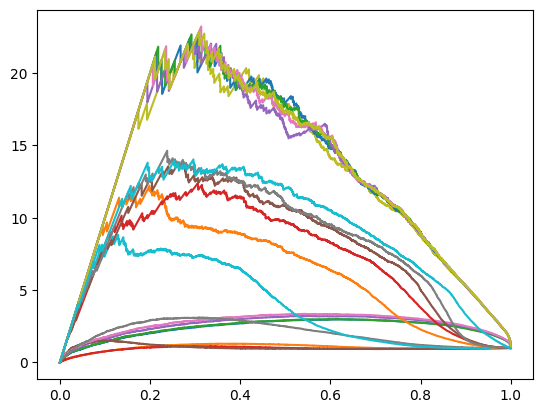

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

qq = 'qq'

xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

for sigfrac in np.logspace(-3,-1,10):
    print(sigfrac)
    #sigfrac = 0.05
    
    w1 = 2
    w2 = 5
    if (sigfrac > 0.5):
        continue

    for l in model_qq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(2.))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(5.))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1)
    LLR_xs = 1.+sigfrac*LLR - sigfrac
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs+0.0001)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3.5
    m2 = 5.5

    test_background = int(1/2 *len(x[0,0, qq]))
    train_background = int(1/4 * len(x[0,0,qq]))
    train_data = int(1/4 * len(x[0,0,qq]))
    train_reference = int(1/4 * len(x[0,0,qq]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2,qq]))
    sig_frac = sigfrac

    N = int(1/4 * len(x[0,0,qq]))
    signal = x[m1,m2,qq][test_signal_length:test_signal_length+int(sig_frac*N)]

    x_vals_ = np.concatenate([x[0,0,qq][test_background:],signal])
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

    print(N,len(x[0,0,qq])-N,len(x[m1,m2,qq][0:int(sig_frac*N)]),len(x[m1,m2,qq][0:int(sig_frac*N)])/N)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)    

    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=6, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)

    scores2 = model_cwola.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr+0.0001))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2+0.0001))

    msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]

(0.0, 700.0)

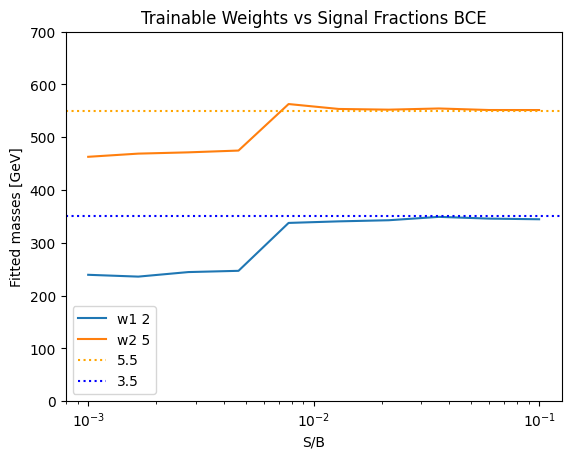

In [87]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

Text(0, 0.5, 'Max SIC')

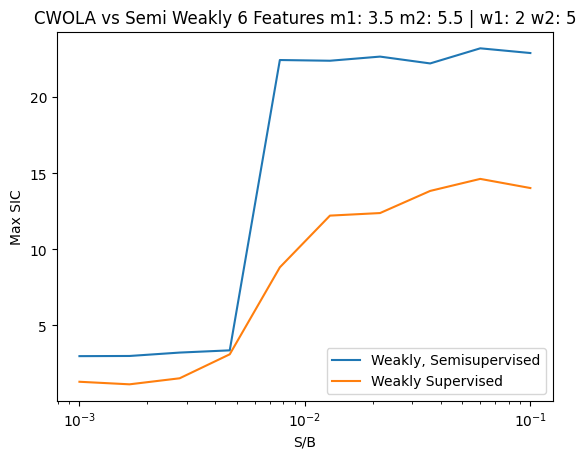

In [88]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly 6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2}")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

0.001
30338 91014 30 0.0009888588568791614
3.5 5.5 2.4973376 4.5801206
92/92 [==============================] - 0s 2ms/step
0.0012742749857031334
30338 91014 38 0.0012525545520469378
3.5 5.5 2.5219393 4.7018037
92/92 [==============================] - 0s 2ms/step
0.001623776739188721
30338 91014 49 0.0016151361329026304
3.5 5.5 2.5088036 4.6167593
92/92 [==============================] - 0s 2ms/step
0.00206913808111479
30338 91014 62 0.002043641637550267
3.5 5.5 2.5171916 4.715999
92/92 [==============================] - 0s 1ms/step
0.0026366508987303583
30338 91014 79 0.002603994989781792
3.5 5.5 2.5067606 4.7226763
92/92 [==============================] - 0s 2ms/step
0.003359818286283781
30338 91014 101 0.003329158151493177
3.5 5.5 2.5678015 4.726885
92/92 [==============================] - 0s 2ms/step
0.004281332398719396
30338 91014 129 0.004252093084580394
3.5 5.5 2.550902 4.7259884
92/92 [==============================] - 0s 2ms/step
0.00545559478116852
30338 91014 165 0.00543872

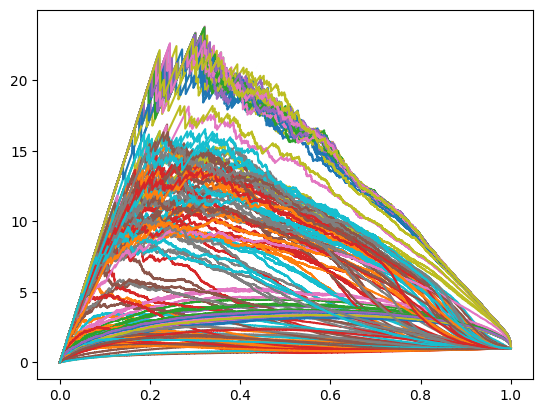

In [94]:
msic1_runs = []
msic2_runs = []
initial_weights_list_runs = []

num_runs = 5

for _ in range(num_runs):
    
    qq = 'qq'

    xx = []
    yy = []
    zz = []
    ww = []

    msic1 = []
    msic2 = []

    for sigfrac in np.logspace(-3,-1,20):
        print(sigfrac)
        #sigfrac = 0.05

        w1 = 2
        w2 = 5
        if (sigfrac > 0.5):
            continue

        for l in model_qq.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(2.))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(5.))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(6,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_qq(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1)
        #LLR_xs = 1.+sigfrac*LLR - sigfrac
        LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        ws = LLR_xs / (1.+LLR_xs+0.0001)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3.5
        m2 = 5.5

        test_background = int(1/2 *len(x[0,0, qq]))
        train_background = int(1/4 * len(x[0,0,qq]))
        train_data = int(1/4 * len(x[0,0,qq]))
        train_reference = int(1/4 * len(x[0,0,qq]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2,qq]))
        sig_frac = sigfrac

        #randomize signal events
        random_test_signal_length = random.randint(0, test_signal_length - 1)
        N = int(1/4 * (len(x[0,0,qq])))
        signal = x[m1, m2,qq][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0,qq][test_background:],signal])
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

        print(N,len(x[0,0,qq])-N,len(x[m1,m2,qq][0:int(sig_frac*N)]),len(x[m1,m2,qq][0:int(sig_frac*N)])/N)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)    

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=6, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,tpr/np.sqrt(fpr+0.0001))
        plt.plot(tpr2,tpr2/np.sqrt(fpr2+0.0001))

        msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
        msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]
        
    msic1_runs.append(msic1)
    msic2_runs.append(msic2)

Text(0, 0.5, 'Avg Max SIC')

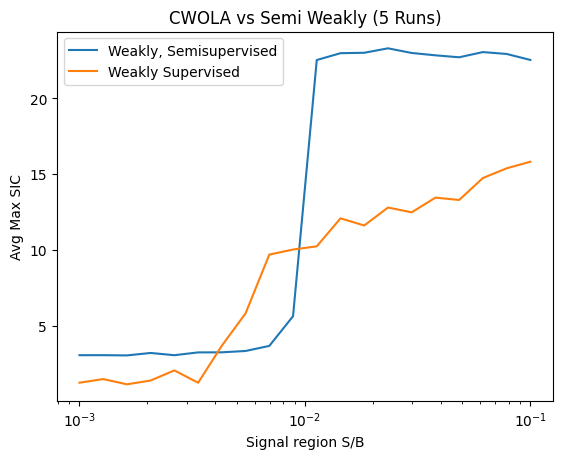

In [90]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
plt.plot(xx,avgmsic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

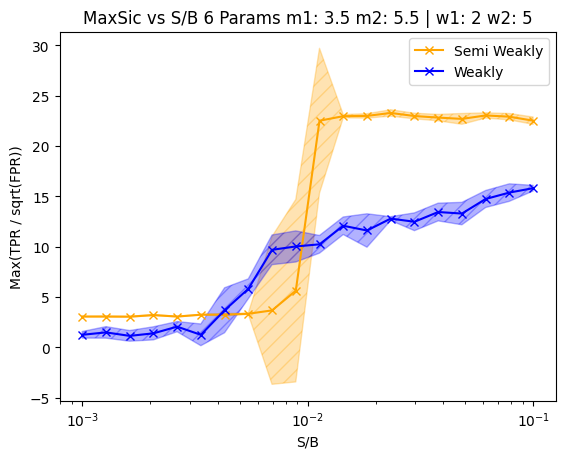

In [93]:
signal_fraction_values = np.logspace(-3, -1, 20)

maxsic1 = avgmsic1
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = msicstds1

maxsic2 = avgmsic2
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = msicstds2

plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')
plt.ylabel('Max(TPR / sqrt(FPR))')
plt.title(f'MaxSic vs S/B 6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend()
plt.show()

Text(0, 0.5, 'Avg Max SIC')

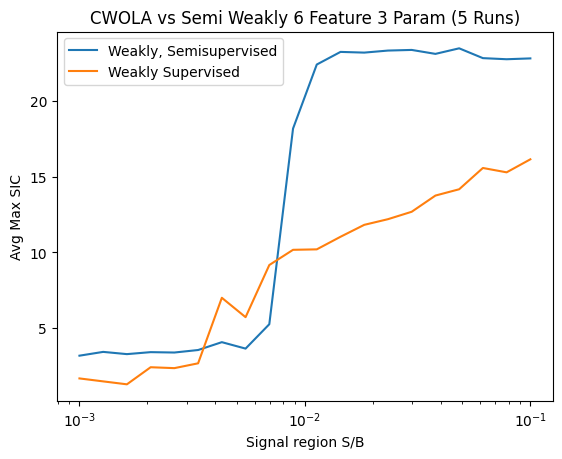

In [95]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
plt.plot(xx,avgmsic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly 6 Feature 3 Param ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

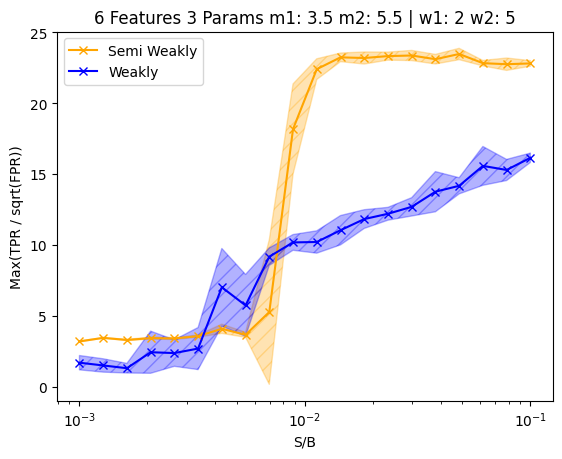

In [96]:
signal_fraction_values = np.logspace(-3, -1, 20)

maxsic1 = avgmsic1
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = msicstds1

maxsic2 = avgmsic2
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = msicstds2

plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')
plt.ylabel('Max(TPR / sqrt(FPR))')
plt.title(f'6 Features 3 Params m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend()
plt.show()

Text(0, 0.5, 'Fitted S/B')

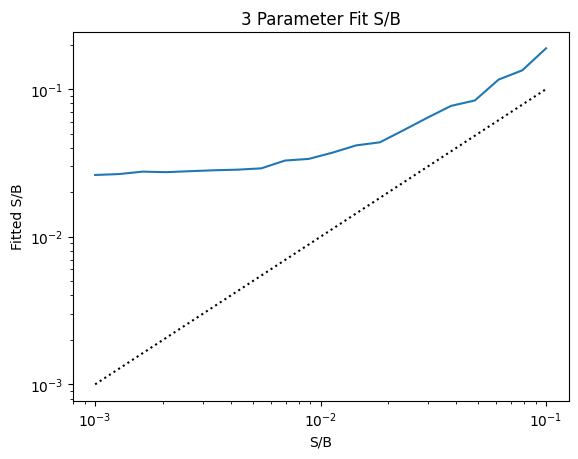

In [97]:
plt.plot(xx,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(xx,xx,ls=":",color="black")
plt.title("3 Parameter Fit S/B")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")